# Default Prediction Multi-Layer-Perceptron Model

In [1]:
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import kagglehub

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tabulate import tabulate

In [2]:
def plot_loss(title, history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_accuracy(title, history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='red')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Preparing The Data

In [4]:
default_data = pd.read_csv("default of credit card clients.csv", header=1)

In [5]:
print(default_data.head())

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

In [6]:
default_data.drop(columns=['ID'],inplace = True)

In [7]:
X = default_data.iloc[:, :-1].values
y = default_data.iloc[:, -1].values  

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape)
print(" Training labels:", y_train.shape)
print(" Testing samples:", X_test.shape)
print("  Testing labels:", y_test.shape)

Training samples: (24000, 23)
 Training labels: (24000,)
 Testing samples: (6000, 23)
  Testing labels: (6000,)


In [8]:
n_features = X_train.shape[1]
n_features

23

# Creating the Model

In [10]:
model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {accuracy:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.7756 - loss: 0.6523
Validation Accuracy: 0.7783


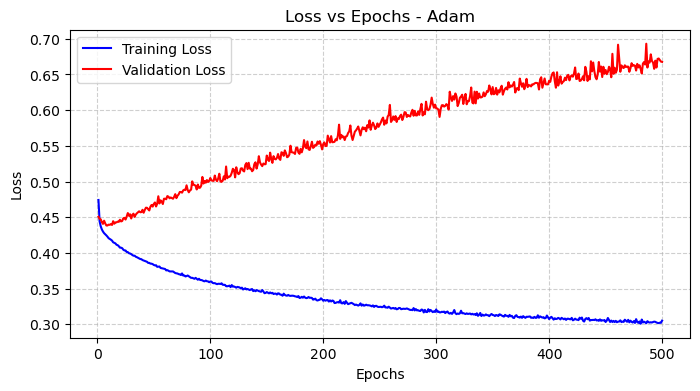

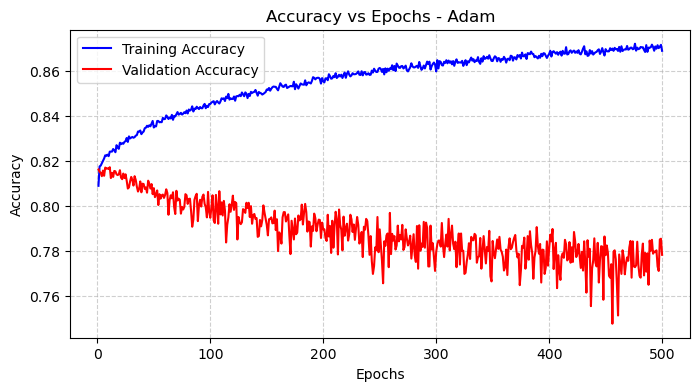

In [13]:
plot_loss('Loss vs Epochs - Adam', history)
plot_accuracy('Accuracy vs Epochs - Adam', history)

### Adding Regularisation

In [15]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.003), input_shape=(n_features,)))
model2.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.003)))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history2 = model2.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [17]:
loss2, accuracy2 = model2.evaluate(X_test, y_test)
print(f"Validation Accuracy: {accuracy2:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8143 - loss: 0.4393
Validation Accuracy: 0.8187


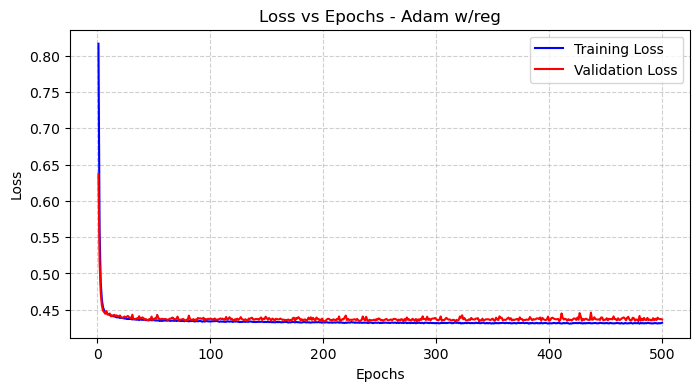

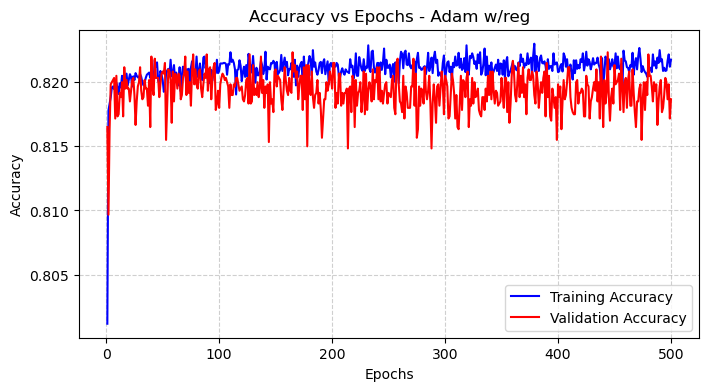

In [18]:
plot_loss('Loss vs Epochs - Adam w/reg', history2)
plot_accuracy('Accuracy vs Epochs - Adam w/reg', history2)

# Trying Different Optimisers

In [20]:
optimizer_list = ['SGD', 'RMSprop','Adagrad','Adam']

In [21]:
def build_compile(optimizer_name):
    
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer_name, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

In [22]:
hist_acc_nn = []
hist_val_acc_nn = []
hist_loss_nn = []
hist_val_loss_nn = []

epochs = 100

for item in optimizer_list:
    print("-----------------------------")
    print("Doing %s optimizer" %str(item))
    print("-----------------------------")

    model = build_compile(item)

    history = model.fit(X_train, y_train, epochs = epochs, batch_size = 32, validation_data = (X_test, y_test), verbose = 0)

    hist_acc_nn.append(history.history['accuracy'])
    hist_val_acc_nn.append(history.history['val_accuracy'])
    hist_loss_nn.append(history.history['loss'])
    hist_val_loss_nn.append(history.history['val_loss'])

    print("-----------------------------")


-----------------------------
Doing SGD optimizer
-----------------------------


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

-----------------------------
-----------------------------
Doing RMSprop optimizer
-----------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

-----------------------------
-----------------------------
Doing Adagrad optimizer
-----------------------------


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

-----------------------------
-----------------------------
Doing Adam optimizer
-----------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

-----------------------------


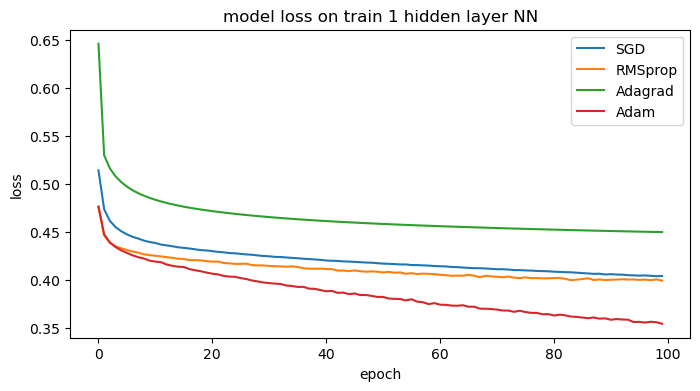

In [23]:
plt.figure(figsize=(8, 4))
for i in range(len(optimizer_list)):
    plt.plot(hist_loss_nn[i],label=str(optimizer_list[i]))
plt.title('model loss on train 1 hidden layer NN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

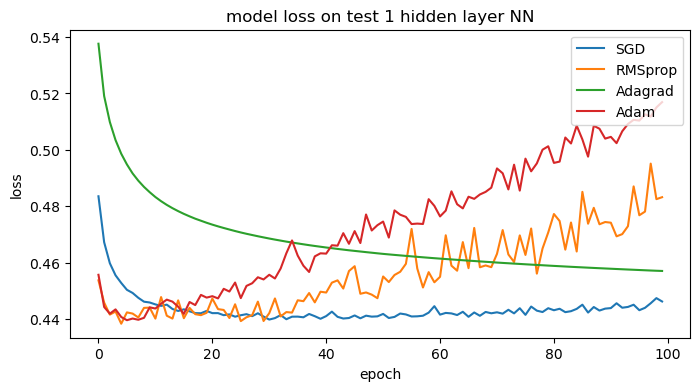

In [24]:
plt.figure(figsize=(8, 4))
for i in range(len(optimizer_list)):
    plt.plot(hist_val_loss_nn[i], label=str(optimizer_list[i]))
plt.title('model loss on test 1 hidden layer NN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# New Model With Stochastic Gradient Descent

In [26]:
model3 = Sequential()
model3.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model3.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_new = model3.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [28]:
loss3, accuracy3 = model3.evaluate(X_test, y_test)
print(f"Validaiton Accuracy: {accuracy3:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7959 - loss: 0.5230
Validaiton Accuracy: 0.7990


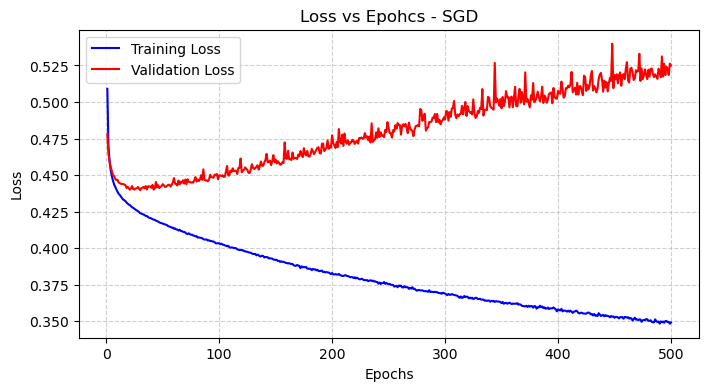

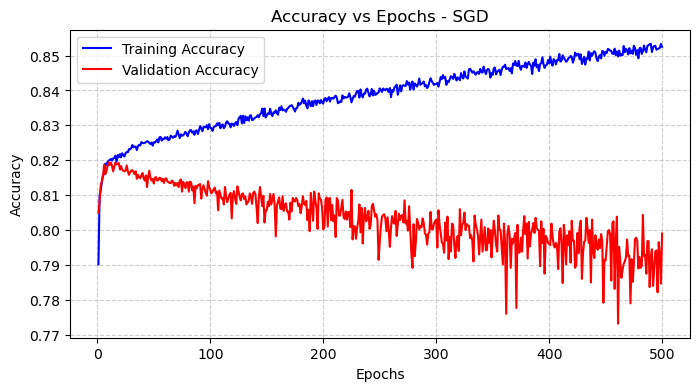

In [29]:
plot_loss('Loss vs Epohcs - SGD', history_new)
plot_accuracy('Accuracy vs Epochs - SGD', history_new)

### Adding Regularization

In [31]:
model4 = Sequential()

model4.add(Dense(64,activation='relu', input_shape = (n_features,),kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.003)))
model4.add(Dense(64,activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.003)))
model4.add(Dense(1,activation='sigmoid'))
model4.summary()

model4.compile(loss='binary_crossentropy', optimizer='SGD',metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,761 (22.50 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_new_reg = model4.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [33]:
loss4, accuracy4 = model4.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy4:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.8160 - loss: 0.4439
Test Accuracy: 0.8207


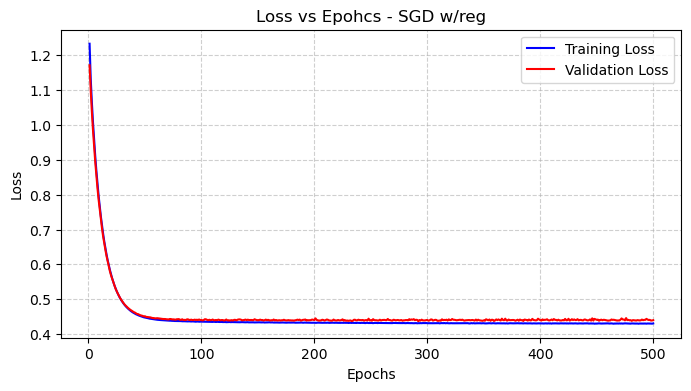

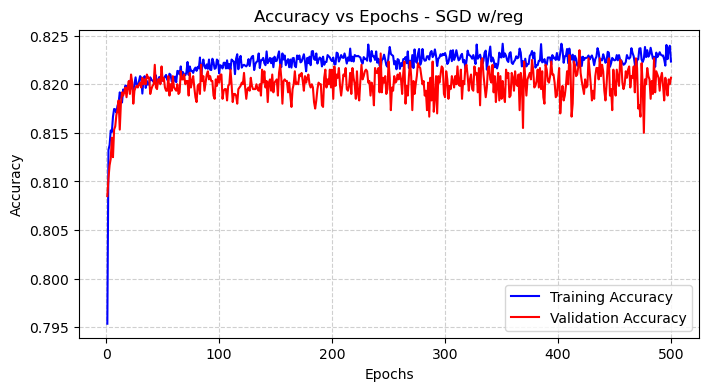

In [34]:
plot_loss('Loss vs Epohcs - SGD w/reg', history_new_reg)
plot_accuracy('Accuracy vs Epochs - SGD w/reg', history_new_reg)

# Evaluation

In [88]:
table_data = [
    ["Adam", accuracy, loss],
    ["Adam + Regularization", accuracy2, loss2],
    ["SGD", accuracy3, loss3],
    ["SGD + Regularization", accuracy4, loss4]
]

headers = ["Optimizer", "Test Accuracy", " Test Loss"]

print(tabulate(table_data, headers=headers, tablefmt="heavy_grid", showindex=False))

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Optimizer             ┃   Test Accuracy ┃    Test Loss ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ Adam                  ┃        0.778333 ┃     0.667601 ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ Adam + Regularization ┃        0.818667 ┃     0.436494 ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ SGD                   ┃        0.799    ┃     0.524983 ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ SGD + Regularization  ┃        0.820667 ┃     0.439692 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┛


In [56]:
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
X_sample = X_test[random_indices]
y_true_sample = y_test[random_indices]

y_pred_prob = model4.predict(X_sample)
y_pred = (y_pred_prob > 0.5).astype(int)

output_data = []
for true_label, pred_label in zip(y_true_sample, y_pred.flatten()):
    actual = "Default" if true_label == 1 else "No Default"
    predicted = "Default" if pred_label == 1 else "No Default"
    correct = "Yes" if true_label == pred_label else "No"
    output_data.append([actual, predicted, correct])

output_df = pd.DataFrame(output_data, columns=["Actual", "Predicted", "Correct"])

print("Model Predictions Using SGD with Regularisation (Sample)")
print(tabulate(output_df, headers="keys", tablefmt="heavy_grid", showindex=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model Predictions Using SGD with Regularisation (Sample)
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Actual     ┃ Predicted   ┃ Correct   ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ Default    ┃ Default     ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ Default    ┃ Default     ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ Default    ┃ Default     ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ No Default ┃ No Default  ┃ Yes       ┃
┗━━